In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49462 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:49465" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:49484, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:49487, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:49490, threads: 2>})

In [4]:
train_X = pd.read_pickle('DFs/train_test/train_X.pkl')
train_y = pd.read_pickle('DFs/train_test/train_y.pkl')
test_X = pd.read_pickle('DFs/train_test/test_X.pkl')
test_y = pd.read_pickle('DFs/train_test/test_y.pkl')

In [5]:
f = open(r'DFs/train_test/participants.pkl', 'rb')
participants = pickle.load(f)
f.close()

In [6]:
from model_prep import score_model

In [7]:
from model_prep import plot_predictions

# SGD Classifier OOB

In [8]:
sgd = SGDRegressor()
pca50 = PCA(n_components=50)
train_X_pca50 = pca50.fit_transform(train_X)
test_X_pca50 = pca50.transform(test_X)
with joblib.parallel_backend('dask'):
    sgd.fit(train_X_pca50, train_y) 

In [9]:
sgd_scores = {'model':[],'par':[],'MAPE':[], 'MAE':[]}
for param in sgd.get_params():
    sgd_scores[param]=[]

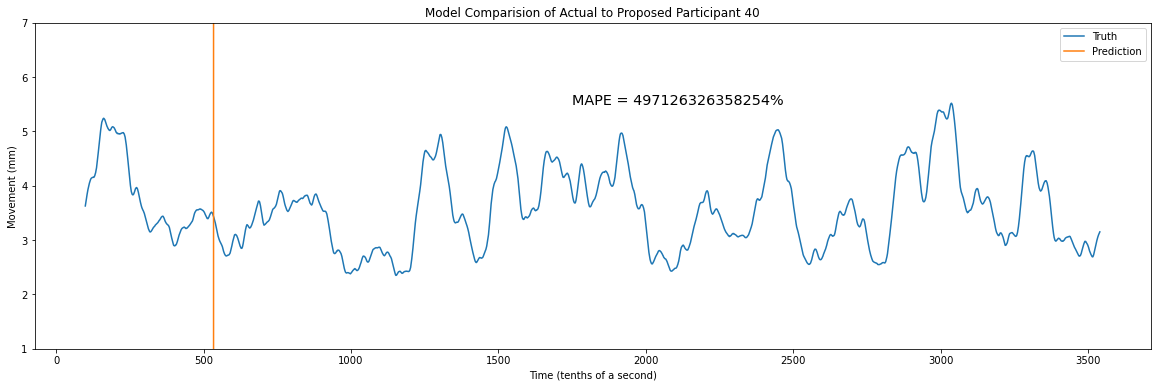

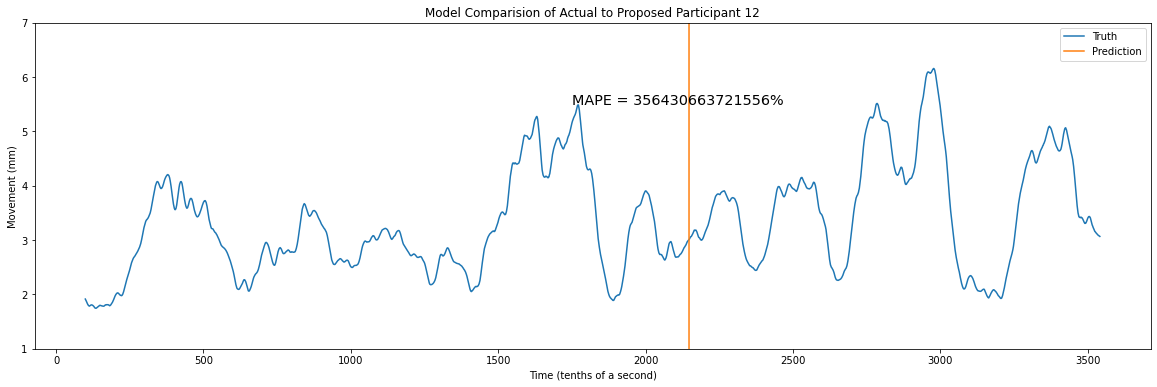

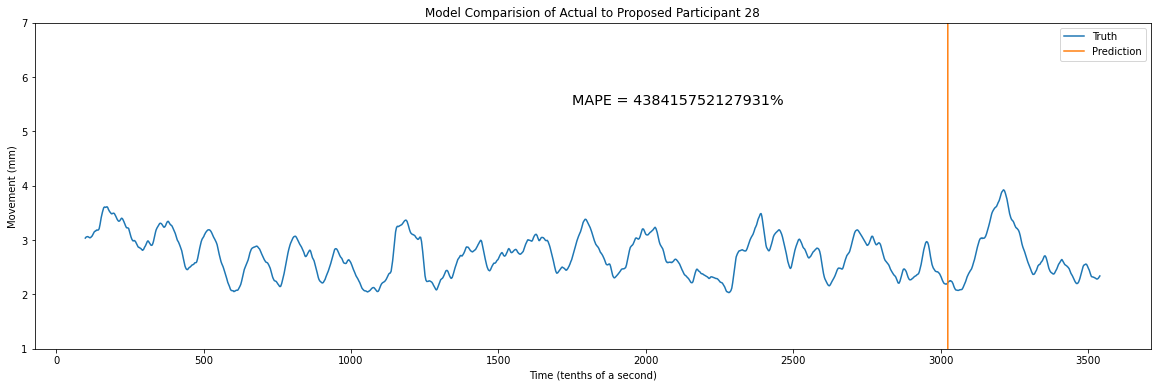

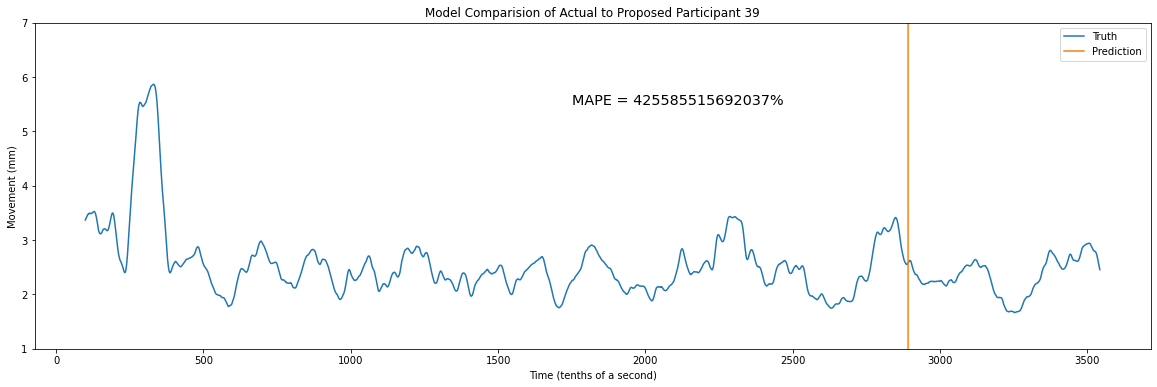

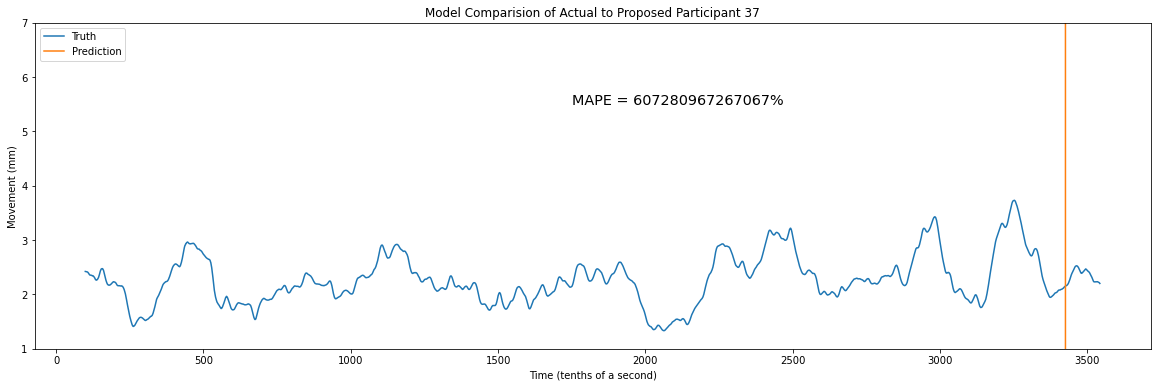

In [10]:
results, sgd_scores = score_model(sgd, participants=participants, test_y=test_y, test_X=test_X_pca50, 
                      model_name='SGD', log = sgd_scores)
plot_predictions(results, participants)

In [17]:
pred = sgd.predict(test_X_pca50)
pred

array([ 1.89795804e+13,  1.89795804e+13,  2.36473858e+13, ...,
       -1.45824425e+12, -1.21864413e+12, -1.21864413e+12])

In [11]:
sgd_scores.keys()

dict_keys(['model', 'par', 'MAPE', 'MAE', 'alpha', 'average', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [12]:
sgd_df = pd.DataFrame(sgd_scores)

In [13]:
sgd_df.groupby(['par','model']).mean()

,,MAPE,MAE,alpha,average,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,max_iter,n_iter_no_change,power_t,shuffle,tol,validation_fraction,verbose,warm_start
par,model,,,,,,,,,,,,,,,,,
12,SGD,3.564307e+12,9.289613e+12,0.0001,False,False,0.1,0.01,True,0.15,1000,5,0.25,True,0.001,0.1,0,False
28,SGD,4.384158e+12,1.066946e+13,0.0001,False,False,0.1,0.01,True,0.15,1000,5,0.25,True,0.001,0.1,0,False
37,SGD,6.072810e+12,1.157904e+13,0.0001,False,False,0.1,0.01,True,0.15,1000,5,0.25,True,0.001,0.1,0,False
39,SGD,4.255855e+12,9.335390e+12,0.0001,False,False,0.1,0.01,True,0.15,1000,5,0.25,True,0.001,0.1,0,False
40,SGD,4.971263e+12,1.478169e+13,0.0001,False,False,0.1,0.01,True,0.15,1000,5,0.25,True,0.001,0.1,0,False


In [14]:
sgd_df.groupby(['model']).mean()

,par,MAPE,MAE,alpha,average,early_stopping,epsilon,eta0,fit_intercept,l1_ratio,max_iter,n_iter_no_change,power_t,shuffle,tol,validation_fraction,verbose,warm_start
model,,,,,,,,,,,,,,,,,,
SGD,31.2,4.649678e+12,1.113104e+13,0.0001,False,False,0.1,0.01,True,0.15,1000.0,5.0,0.25,True,0.001,0.1,0.0,False


In [15]:
sgd_df.to_pickle(r'DFs/scores/sgd.pkl')